# Benchmarks analysis

This notebook aims to assess our model's performances on two synthetic benchkmarks of abnormalities:
- deletion benchmark: simple surfaces of various sizes have been randomly deleted
- asymmetry benchmark: equivalent crop but on left hemisphere and then flipped

In [1]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import SkeletonDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.svm import LinearSVC

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"

In [3]:
model_dir = '/neurospin/dico/lguillon/distmap/gridsearch_lr5e-4/n_75_kl_2/checkpoint.pt'
model = VAE((1, 80, 80, 96), 75, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

In [4]:
data_dir = "/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/"
df_encoded_hcp = pd.read_pickle(os.path.join(data_dir, "encoded_hcp.pkl"))

### Loading of deletion benchmark

In [5]:
data_dir = "/neurospin/dico/lguillon/distmap/benchmark/deletion_no_junction/"
data_path = "crops/1mm/SC"

In [6]:
distmaps_200 = np.load(os.path.join(data_dir, "200", data_path, "200_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_200 = np.load(os.path.join(data_dir, "200", data_path, "sub_id.npy"))

subset_200 = SkeletonDataset(dataframe=distmaps_200,
                         filenames=filenames_200,
                         data_transforms=False)
loader_200 = torch.utils.data.DataLoader(
               subset_200,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_500 = np.load(os.path.join(data_dir, "500", data_path, "500_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_500 = np.load(os.path.join(data_dir, "500", data_path, "sub_id.npy"))

subset_500 = SkeletonDataset(dataframe=distmaps_500,
                         filenames=filenames_500,
                         data_transforms=False)
loader_500 = torch.utils.data.DataLoader(
               subset_500,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_700 = np.load(os.path.join(data_dir, "700", data_path, "700_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_700 = np.load(os.path.join(data_dir, "700", data_path, "sub_id.npy"))

subset_700 = SkeletonDataset(dataframe=distmaps_700,
                         filenames=filenames_700,
                         data_transforms=False)
loader_700 = torch.utils.data.DataLoader(
               subset_700,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_1000 = np.load(os.path.join(data_dir, "1000", data_path, "1000_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_1000 = np.load(os.path.join(data_dir, "1000", data_path, "sub_id.npy"))

subset_1000 = SkeletonDataset(dataframe=distmaps_1000,
                         filenames=filenames_1000,
                         data_transforms=False)
loader_1000 = torch.utils.data.DataLoader(
               subset_1000,
               batch_size=1,
               num_workers=1,
               shuffle=False)

In [ ]:
dico_set_loaders = {'200': loader_200, '500': loader_500, '700': loader_700, '1000': loader_1000}

root_dir = '/neurospin/dico/lguillon/distmap/benchmark/results/'

criterion = nn.MSELoss(reduction='sum')
tester_deletion = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_deletion = tester_deletion.test()
encoded_deletion = {loader_name:[results_deletion[loader_name][k][1] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_deletion = {loader_name:[int(results_deletion[loader_name][k][0].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_deletion = {loader_name:[int(results_deletion[loader_name][k][2].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_deletion = {loader_name:[results_deletion[loader_name][k][3].cpu().detach().numpy() for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
var_deletion = {loader_name:[results_deletion[loader_name][k][4] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

200
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.7642975e-05 2.4557114e-05 ... 9.9954069e-01 9.9955142e-01
 9.9981844e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 8.5115433e-05 9.1791153e-05 ... 9.9941254e-01 9.9962616e-01
 9.9975431e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.6450882e-05 2.5510788e-05 ... 9.9918818e-01 9.9940193e-01
 9.9992526e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 8.1062317e-06 1.0251999e-05 ... 9.9878240e-01 9.9950385e-01
 9.9991226e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.5497208e-05 1.7642975e-05 ... 9.9899602e-01 9.9912417e-01
 9.9957907e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.1457672e-05 2.1696091e-05 ... 9.9963152e-01 9.9969029e-01
 9.9971163e

ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
[0.00000000e+00 1.09910965e-04 1.18255615e-04 ... 9.98583078e-01
 9.99241590e-01 9.99946594e-01]
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.5568733e-04 1.6880035e-04 ... 9.9968493e-01 9.9983442e-01
 9.9993587e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 8.3446503e-06 9.7751617e-06 ... 9.9910271e-01 9.9923635e-01
 9.9955666e-01]
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 3.1471252e-05 3.4570694e-05 ... 9.9928975e-01 9.9959409e-01
 9.9981308e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.7070770e-04 1.9001961e-04 ... 9.9914551e-01 9.9938226e-01
 9.9976504e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.4795532e-05 3.9577484e-05 ... 9.9981713e-01 9.9985051e-01
 9.9985576e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 6

ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.000000e+00 9.083748e-05 9.703636e-05 ... 9.985260e-01 9.986541e-01
 9.996475e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 3.3617020e-05 3.5047531e-05 ... 9.9905849e-01 9.9954069e-01
 9.9971163e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 3.9339066e-05 4.2676926e-05 ... 9.9880373e-01 9.9939120e-01
 9.9939656e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 4.6491623e-05 5.6505203e-05 ... 9.9955666e-01 9.9980724e-01
 9.9987185e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.00000000e+00 1.50203705e-05 1.64508820e-05 ... 9.98910546e-01
 9.99919891e-01 9.99994636e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.2888184e-05 2.8848648e-05 ... 9.9898565e-01 9.9915087e-01
 9.9921489e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.00000000e+00 1.14917755e-

(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.8610229e-06 5.2452087e-06 ... 9.9908316e-01 9.9935913e-01
 9.9955142e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 5.4597855e-05 6.1035156e-05 ... 9.9912417e-01 9.9947667e-01
 9.9949801e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 5.0306320e-05 5.2928925e-05 ... 9.9897456e-01 9.9907076e-01
 9.9976504e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.3365021e-05 2.4795532e-05 ... 9.9846256e-01 9.9883580e-01
 9.9974358e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.9087067e-05 4.2438507e-05 ... 9.9897850e-01 9.9932706e-01
 9.9956739e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 5.4359436e-05 5.9127808e-05 ... 9.9962080e-01 9.9977577e-01
 9.9996257e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)

[0.000000e+00 2.503395e-05 2.527237e-05 ... 9.985260e-01 9.986541e-01
 9.996475e-01]
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.3841858e-06 2.6226044e-06 ... 9.9904406e-01 9.9918818e-01
 9.9920428e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.5272369e-05 3.1471252e-05 ... 9.9931109e-01 9.9980724e-01
 9.9987185e-01]
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.7418137e-05 2.8133392e-05 ... 9.9941254e-01 9.9949265e-01
 9.9975431e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 4.5299530e-06 5.2452087e-06 ... 9.9908137e-01 9.9991989e-01
 9.9999464e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.000000e+00 1.835823e-05 2.026558e-05 ... 9.994019e-01 9.995514e-01
 9.997810e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 3.2186508e-05 3.7193298e-05 ... 9.9778128e-01 9.9841392e-01
 

(78, 63, 88, 1)
(78, 63, 88)
ici
[0.0000000e+00 9.5367432e-07 1.1920929e-06 ... 9.9905479e-01 9.9927366e-01
 9.9973297e-01]
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.3113022e-05 1.4543533e-05 ... 9.9973297e-01 9.9987185e-01
 9.9996793e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.6689301e-06 2.6226044e-06 ... 9.9939656e-01 9.9994659e-01
 9.9994743e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.1457672e-06 2.3841858e-06 ... 9.9870765e-01 9.9889362e-01
 9.9983978e-01]
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.6689301e-06 2.1457672e-06 ... 9.9877691e-01 9.9970090e-01
 9.9987185e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.4781952e-05 1.7404556e-05 ... 9.9878240e-01 9.9927366e-01
 9.9978101e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)

(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 5.9604645e-06 6.6757202e-06 ... 9.9898565e-01 9.9915087e-01
 9.9921489e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 6.6757202e-06 8.3446503e-06 ... 9.9996793e-01 9.9997330e-01
 9.9998927e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 3.8146973e-06 4.0531158e-06 ... 9.9940193e-01 9.9955142e-01
 9.9978101e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
[0.0000000e+00 1.2397766e-05 1.8119812e-05 ... 9.9875033e-01 9.9923635e-01
 9.9987185e-01]
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.4305115e-06 1.6689301e-06 ... 9.9916685e-01 9.9967957e-01
 9.9984515e-01]
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 7.1525574e-07 1.1920929e-06 ... 9.9928439e-01 9.9938047e-01
 9.9969554e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.8835068e-05 2.5749

(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
[0.0000000e+00 7.1525574e-06 7.6293945e-06 ... 9.9912417e-01 9.9919891e-01
 9.9953008e-01]
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.3841858e-07 4.7683716e-07 ... 9.9481964e-01 9.9532163e-01
 9.9994659e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 4.7683716e-07 7.1525574e-07 ... 9.9814677e-01 9.9929190e-01
 9.9946070e-01]
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 4.7683716e-07 7.1525574e-07 ... 9.9828029e-01 9.9905479e-01
 9.9967027e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 4.0531158e-06 4.5299530e-06 ... 9.9888921e-01 9.9973297e-01
 9.9987185e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.3841858e-07 4.7683716e-07 ... 9.9878240e-01 9.9923635e-01
 9.9957275e-01]
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.9073486e-06 2.1457

ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.6226044e-06 3.3378601e-06 ... 9.9875569e-01 9.9891591e-01
 9.9929500e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 3.3378601e-06 3.5762787e-06 ... 9.9904978e-01 9.9911344e-01
 9.9989319e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 4.5299530e-06 5.7220459e-06 ... 9.9966884e-01 9.9988246e-01
 9.9991453e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.1920929e-06 1.4305115e-06 ... 9.9843514e-01 9.9973297e-01
 9.9986112e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 8.3446503e-06 9.0599060e-06 ... 9.9880373e-01 9.9920964e-01
 9.9975431e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.4305115e-06 1.6689301e-06 ... 9.9918818e-01 9.9939656e-01
 9.9943388e-01]
(78, 63, 88, 1)
(78, 63, 88)

(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.4305115e-06 1.9073486e-06 ... 9.9884641e-01 9.9900138e-01
 9.9941254e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 3.8146973e-06 5.2452087e-06 ... 9.9944985e-01 9.9958348e-01
 9.9996793e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.3841858e-07 4.7683716e-07 ... 9.9829102e-01 9.9877226e-01
 9.9882507e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.4305115e-06 1.6689301e-06 ... 9.9881434e-01 9.9892294e-01
 9.9936831e-01]
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 9.5367432e-07 1.1920929e-06 ... 9.9729764e-01 9.9880910e-01
 9.9964750e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.6689301e-06 1.9073486e-06 ... 9.9869692e-01 9.9914551e-01
 9.9982917e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.6226044e-06 2.8610229e-06 ... 9.9980772e-01 9.9

In [8]:
df_encoded_deletion = pd.DataFrame()
df_encoded_deletion['latent'] = encoded_deletion['200'] +encoded_deletion['500']+ encoded_deletion['700'] +encoded_deletion['1000']  
df_encoded_deletion['loss'] = losses_deletion['200'] + losses_deletion['500'] + losses_deletion['700'] + losses_deletion['1000'] 
df_encoded_deletion['recon'] = recon_deletion['200'] + recon_deletion['500'] +recon_deletion['700'] + recon_deletion['1000']  
df_encoded_deletion['input'] = input_deletion['200'] + input_deletion['500'] + input_deletion['700'] + input_deletion['1000']
df_encoded_deletion['sub'] = list(filenames_200) + list(filenames_500) + list(filenames_700) + list(filenames_1000)
df_encoded_deletion['group'] = ['200' for k in range(len(list(filenames_200)))] + ['500' for k in range(len(list(filenames_500)))] + ['700' for k in range(len(list(filenames_700)))] + ['1000' for k in range(len(list(filenames_1000)))]

In [9]:
deletion_200 = pd.DataFrame()
deletion_200['latent'] = encoded_deletion['200']
deletion_200['loss'] = losses_deletion['200']  
deletion_200['recon'] = recon_deletion['200']   
deletion_200['input'] = input_deletion['200'] 
deletion_200['sub'] = list(filenames_200) 

In [10]:
deletion_500 = pd.DataFrame()
deletion_500['latent'] = encoded_deletion['500']  
deletion_500['loss'] = losses_deletion['500'] 
deletion_500['recon'] = recon_deletion['500']  
deletion_500['input'] = input_deletion['500']
deletion_500['sub'] = list(filenames_500)

deletion_700 = pd.DataFrame()
deletion_700['latent'] = encoded_deletion['700']  
deletion_700['loss'] = losses_deletion['700'] 
deletion_700['recon'] = recon_deletion['700']  
deletion_700['input'] = input_deletion['700']
deletion_700['sub'] = list(filenames_700)

deletion_1000 = pd.DataFrame()
deletion_1000['latent'] = encoded_deletion['1000']  
deletion_1000['loss'] = losses_deletion['1000'] 
deletion_1000['recon'] = recon_deletion['1000']  
deletion_1000['input'] = input_deletion['1000']
deletion_1000['sub'] = list(filenames_1000)

In [11]:
df_200_500 = pd.merge(deletion_200, deletion_500, how='inner', on='sub')
df_700_1000 = pd.merge(deletion_700, deletion_1000, how='inner', on='sub')
deletion_all = pd.merge(df_200_500, df_700_1000, how='inner', on='sub')

In [12]:
len(deletion_all)

10

## D_{L} metric computation

#### Train data

In [12]:
data_dir = '/neurospin/dico/lguillon/distmap/data/'
filenames_all = np.load(os.path.join(data_dir,
                                "train_sub_id.npy"))
distmaps = np.load(os.path.join(data_dir,
                                "train_distmap.npy"),
                       mmap_mode='r')

subset_sc = SkeletonDataset(dataframe=distmaps, filenames=filenames_all, data_transforms=False)
sc_loader = torch.utils.data.DataLoader(
                          subset_sc,
                          batch_size=8,
                          num_workers=8,
                          shuffle=False)

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders={'hcp_train': sc_loader},
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp_all = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
losses_hcp_all = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
recon_hcp_all = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
input_hcp_all = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
var_hcp_all = {loader_name:[results_hcp[loader_name][k][4] for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}

df_encoded_hcp_all = pd.DataFrame()
df_encoded_hcp_all['latent'] = encoded_hcp_all['hcp_train']
df_encoded_hcp_all['loss'] = losses_hcp_all['hcp_train']
df_encoded_hcp_all['recon'] = recon_hcp_all['hcp_train']
df_encoded_hcp_all['input'] = input_hcp_all['hcp_train']
df_encoded_hcp_all['var'] = var_hcp_all['hcp_train']
df_encoded_hcp_all['Group'] = ['hcp_train' for k in range(len(filenames_all))] 
df_encoded_hcp_all['sub'] = list(filenames_all)

hcp_train
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 

(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(78, 63, 88, 1)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78

ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
[0.0000000e+00 1.3589859e-05 1.4066696e-05 ... 9.9979174e-01 9.9981844e-01
 9.9993587e-01]
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
ici
(1, 78, 63, 88, 1)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(78, 63,

(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 3.3140182e-05 3.9339066e-05 ... 9.9991453e-01 9.9994659e-01
 9.9996793e-01]
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(78, 63, 88, 1)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 6.4373016e-06 7.6293945e-06 ... 9.9996853e-01 9.9997520e-01
 9.9998391e-01]
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 

(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 

ici
ici
(1, 78, 63, 88, 1)
(1, 78, 63, 88, 1)
ici
(78, 63, 88)
(78, 63, 88)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
ici
ici
(1, 78, 63, 88, 1)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 3.2424927e-05 3.3617020e-05 ... 9.9990392e-01 9.9992526e-01
 9.9998927e-01]
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88, 1)
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 4.5537949e-05 6.1035156e-05 ... 9.9981844e-01 9.9983978e-01
 9.9997330e-01]
(78, 63, 88, 1)
(78, 63, 88

(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
[0.0000000e+00 2.3126602e-05 2.3841858e-05 ... 9.9994659e-01 9.9995196e-01
 9.9995720e-01]
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
ici
(78, 63, 88)
(1, 78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 6.6757202e-06 7.8678131e-06 ... 9.9987721e-01 9.9994135e-01
 9.9998546e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 6

(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.4557114e-05 3.0755997e-05 ... 9.9981844e-01 9.9982381e-01
 9.9983442e-01]
(78, 63, 88, 1)
(78, 63, 88)
(78, 6

#### Test data

In [13]:
subject_dir = "/neurospin/dico/lguillon/distmap/data/"
data_dir = "/neurospin/dico/lguillon/distmap/data/"
test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))
distmaps = np.load(os.path.join(data_dir, "test_distmap.npy"),
                   mmap_mode='r')
filenames = np.load(os.path.join(data_dir, "test_sub_id.npy"))
print(distmaps.shape, filenames.shape)

subset = SkeletonDataset(dataframe=distmaps,
                         filenames=filenames,
                         data_transforms=False)
testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False)

dico_set_loaders_hcp = {'hcp': testloader}

root_dir = '/neurospin/dico/lguillon/distmap/analyses_gridsearch/'

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders=dico_set_loaders_hcp,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
losses_hcp = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
recon_hcp = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
input_hcp = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
var_hcp = {loader_name:[results_hcp[loader_name][k][4] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}

df_encoded_hcp = pd.DataFrame()
df_encoded_hcp['latent'] = encoded_hcp['hcp']
df_encoded_hcp['loss'] = losses_hcp['hcp']
df_encoded_hcp['recon'] = recon_hcp['hcp']
df_encoded_hcp['input'] = input_hcp['hcp']
df_encoded_hcp['var'] = var_hcp['hcp']
df_encoded_hcp['Group'] = ['hcp' for k in range(len(filenames))]
df_encoded_hcp['sub'] = list(filenames)

(200, 78, 63, 88, 1) (200,)
hcp
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.8610229e-06 5.2452087e-06 ... 9.9908316e-01 9.9935913e-01
 9.9955142e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.6450882e-05 1.6689301e-05 ... 9.9897456e-01 9.9975324e-01
 9.9990916e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.7642975e-05 2.4557114e-05 ... 9.9955142e-01 9.9978638e-01
 9.9981844e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.000000e+00 9.083748e-05 9.703636e-05 ... 9.985260e-01 9.986541e-01
 9.996475e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 7.6055527e-05 9.8228455e-05 ... 9.9942851e-01 9.9949801e-01
 9.9971688e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.4615059e-04 1.6379356e-04 ... 9.9816823e-01 9.9860609e-01
 9.9962616e-01]
(7

(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.8930435e-04 1.9669533e-04 ... 9.9945009e-01 9.9981844e-01
 9.9992430e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.1672249e-04 2.3865700e-04 ... 9.9953008e-01 9.9961019e-01
 9.9998927e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
[0.0000000e+00 4.2676926e-05 6.4373016e-05 ... 9.9908841e-01 9.9947536e-01
 9.9996257e-01]
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
[0.00000000e+00 1.14917755e-04 1.35660172e-04 ... 9.99967933e-01
 9.99973297e-01 9.99989271e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
[0.00000000e+00 1.09195709e-04 1.20162964e-04 ... 9.97842431e-01
 9.98130798e-01 9.98269677e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 5.0067902e-06 6.1988831e-06 ... 9.9937522e-01 9.9970090e-01
 9.9987185e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.

[0.000000e+00 7.081032e-05 9.369850e-05 ... 9.992043e-01 9.993484e-01
 9.995835e-01]
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 1.2040138e-04 1.2135506e-04 ... 9.9920428e-01 9.9935913e-01
 9.9967420e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
[0.0000000e+00 5.4597855e-05 6.1035156e-05 ... 9.9947667e-01 9.9948728e-01
 9.9949801e-01]
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
[0.0000000e+00 3.9339066e-05 4.1723251e-05 ... 9.9856639e-01 9.9872887e-01
 9.9962616e-01]
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
[0.0000000e+00 1.5497208e-05 1.7642975e-05 ... 9.9912417e-01 9.9927366e-01
 9.9957907e-01]
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.4127960e-04 2.4199486e-04 ... 9.9941254e-01 9.9962616e-01
 9.9975431e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.00000000e+00 1.21593475e-04 1.80244446e-04 ... 9.99412537e-01
 9.99492645e-01 9.997

(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 5.7458878e-05 6.6757202e-05 ... 9.9912417e-01 9.9919891e-01
 9.9953008e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
[0.00000000e+00 1.01566315e-04 1.20878220e-04 ... 9.99519348e-01
 9.99551415e-01 9.99786377e-01]
(78, 63, 88, 1)
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 2.2697449e-04 2.2721291e-04 ... 9.9948728e-01 9.9965823e-01
 9.9982917e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 3.3855438e-05 4.1961670e-05 ... 9.9848330e-01 9.9868631e-01
 9.9904704e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
[0.0000000e+00 2.0265579e-05 2.0742416e-05 ... 9.9959409e-01 9.9971163e-01
 9.9976504e-01]
(78, 63, 88)
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 88, 1)
(78, 63, 88)
[0.0000000e+00 9.3460083e-05 9.5129013e-05 ... 9.9902391e-01 9.9915707e-01
 9.9951935e-01]
ici
(1, 78, 63, 88, 1)
(78, 63, 88)
(78, 63, 

In [17]:
def dev(latent_sub, var_sub):
    """
    """
    n = len(latent_sub)
    mean_ctrl = [np.mean([encoded_hcp_all['hcp_train'][k][i] for k in range(801)]) for i in range(n)]
    var_ctrl =  [np.var([encoded_hcp_all['hcp_train'][k][i] for k in range(801)]) for i in range(75)]
    deviations = []
    
    for k in range(n):
        deviations.append(abs(latent_sub[k] - mean_ctrl[k])/np.sqrt(var_ctrl[k]+var_sub[k]))
    return(np.mean(deviations))

In [18]:
dev_test = [dev(encoded_hcp['hcp'][k], var_hcp['hcp'][k]) for k in range(len(encoded_hcp['hcp']))]
dev_200 = [dev(encoded_deletion['200'][k], var_deletion['200'][k]) for k in range(len(encoded_deletion['200']))]
dev_500 = [dev(encoded_deletion['500'][k], var_deletion['500'][k]) for k in range(len(encoded_deletion['500']))]
dev_700 = [dev(encoded_deletion['700'][k], var_deletion['700'][k]) for k in range(len(encoded_deletion['700']))]
dev_1000 = [dev(encoded_deletion['1000'][k], var_deletion['1000'][k]) for k in range(len(encoded_deletion['1000']))]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9198cdc710>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9198cdccc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9198cdc4a8>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9198c6d2b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9198c6d588>,
 'means': []}

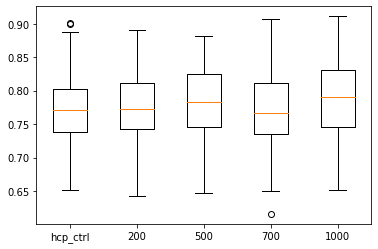

In [19]:
plt.boxplot((dev_test, dev_200, dev_500, dev_700, dev_1000),
            labels=('hcp_ctrl','200', '500', '700', '1000'))

In [20]:
F,p = ks_2samp(dev_test, dev_200)
print(p)
F,p = ks_2samp(dev_test, dev_500)
print(p)
F,p = ks_2samp(dev_test, dev_700)
print(p)
F,p = ks_2samp(dev_test, dev_1000)
print(p)

0.4496416262843729
0.042989108184153274
0.36770698183122275
0.0026570614730754443


### Benchmark 200

In [13]:
list_encoded_200 = random.sample(list(deletion_200['sub']), 90)
df_encoded_200_X = deletion_200[deletion_200['sub'].astype(int).isin(list_encoded_200)]

list_ctrl = list(set(list(deletion_200['sub'].astype(int))) - set(list(df_encoded_200_X['sub'].astype(int))))
df_encoded_hcp_X_200 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [14]:
X_200 = np.array(list(df_encoded_200_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_200['latent']))
X_all = np.array(list(df_encoded_hcp_X_200['latent']) + list(df_encoded_200_X['latent']))

labels_200 = np.array(list(df_encoded_hcp_X_200['Group']) + ['200' for k in range(len(df_encoded_200_X))])
assert(len(X_200)==90)
assert(len(X_hcp)==90)

In [15]:
reducer = umap.UMAP()
embedding_200 = reducer.fit_transform(X_all)

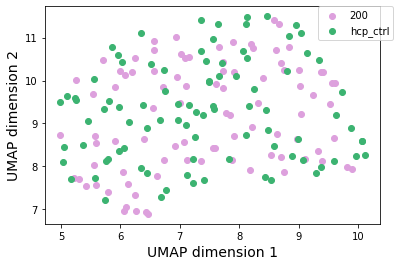

In [19]:
arr = embedding_200
color_dict = {'hcp':'mediumseagreen', '200': 'plum'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_200):
    ix = np.where(labels_200 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='hcp':
        g_lab = 'hcp_ctrl'
    else:
        g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

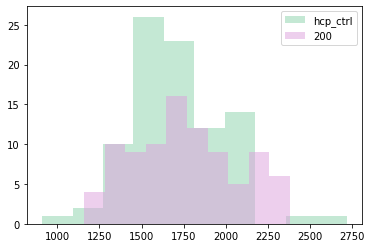

In [26]:
assert(len(df_encoded_hcp_X_200.recon)==90)
assert(len(df_encoded_200_X.recon)==90)
plt.subplot()
plt.hist(df_encoded_hcp_X_200.recon, color='mediumseagreen', alpha=0.3, label='hcp_ctrl',bins=10)
plt.hist(df_encoded_200_X.recon, color='plum', alpha=0.5, label='200', bins=10)
plt.legend()

In [27]:
F,p = mannwhitneyu(df_encoded_hcp_X_200.loss, df_encoded_200_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_200.loss, df_encoded_200_X.loss)
print(p)

0.19261459697718708
0.3755520784929578


### Benchmark 500

In [28]:
list_encoded_500 = random.sample(list(deletion_500['sub']), 34)
df_encoded_500_X = deletion_500[deletion_500['sub'].astype(int).isin(list_encoded_500)]

list_ctrl = list(set(list(deletion_500['sub'].astype(int))) - set(list(df_encoded_500_X['sub'].astype(int))))
df_encoded_hcp_X_500 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [29]:
X_500 = np.array(list(df_encoded_500_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_500['latent']))
X_all = np.array(list(df_encoded_hcp_X_500['latent']) + list(df_encoded_500_X['latent']))

assert(len(X_500)==34)
assert(len(X_hcp)==34)

#X_embedded_500 = TSNE(n_components=2).fit_transform(X_all)
labels_500 = np.array(list(df_encoded_hcp_X_500['Group']) + ['500' for k in range(len(df_encoded_500_X))])
reducer = umap.UMAP()
embedding_500 = reducer.fit_transform(X_all)

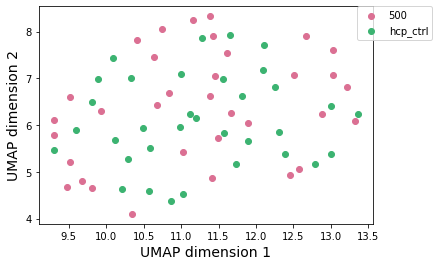

In [30]:
arr = embedding_500
color_dict = {'hcp':'mediumseagreen', '500': 'palevioletred'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_500):
    ix = np.where(labels_500 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='hcp':
        g_lab = 'hcp_ctrl'
    else:
        g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(0.95,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

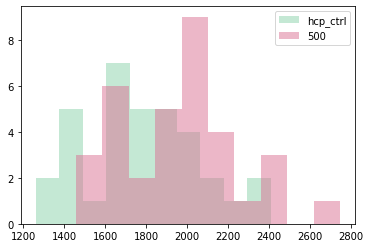

In [33]:
assert(len(df_encoded_hcp_X_500.recon)==34)
assert(len(df_encoded_500_X.recon)==34)
plt.subplot()
plt.hist(df_encoded_hcp_X_500.recon, color='mediumseagreen', alpha=0.3, label='hcp_ctrl')
plt.hist(df_encoded_500_X.recon, color='palevioletred', alpha=0.5, label='500')
plt.legend()

In [32]:
F,p = mannwhitneyu(df_encoded_hcp_X_500.loss, df_encoded_500_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_500.loss, df_encoded_500_X.loss)
print(p)

0.017709188381762102
0.04400727724901782


### Benchmark 700

In [34]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 54)
df_encoded_700_X = deletion_700[deletion_700['sub'].astype(int).isin(list_encoded_700)]

list_ctrl = list(set(list(deletion_700['sub'].astype(int))) - set(list(df_encoded_700_X['sub'].astype(int))))
df_encoded_hcp_X_700 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [35]:
X_700 = np.array(list(df_encoded_700_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_700['latent']))
X_all = np.array(list(df_encoded_hcp_X_700['latent']) + list(df_encoded_700_X['latent']))

assert(len(X_700)==54)
assert(len(X_hcp)==54)

#X_embedded_700 = TSNE(n_components=2).fit_transform(X_all)
labels_700 = np.array(list(df_encoded_hcp_X_700['Group']) + ['700' for k in range(len(df_encoded_700_X))])
reducer = umap.UMAP()
embedding_700 = reducer.fit_transform(X_all)

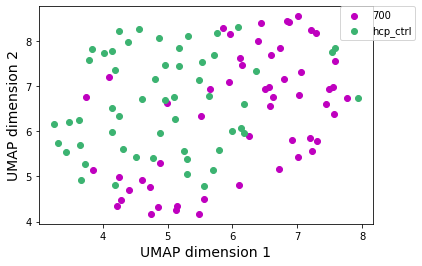

In [39]:
arr = embedding_700
color_dict = {'hcp':'mediumseagreen', '700': 'm'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_700):
    ix = np.where(labels_700 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='hcp':
        g_lab = 'hcp_ctrl'
    else:
        g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(0.9,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

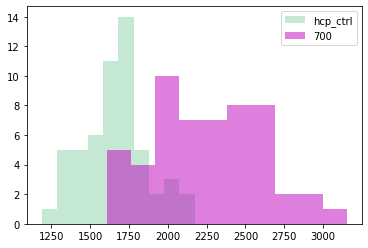

In [40]:
assert(len(df_encoded_hcp_X_700.recon)==54)
assert(len(df_encoded_700_X.recon)==54)
plt.subplot()
plt.hist(df_encoded_hcp_X_700.recon, color='mediumseagreen', alpha=0.3, label='hcp_ctrl')
plt.hist(df_encoded_700_X.recon, color='m', alpha=0.5, label='700')
plt.legend()

In [41]:
F,p = mannwhitneyu(df_encoded_hcp_X_700.loss, df_encoded_700_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_700.loss, df_encoded_700_X.loss)
print(p)

4.772938871733253e-15
5.300909962079917e-14


### Benchmark 1000

In [45]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 75)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].astype(int).isin(list_encoded_1000)]

list_ctrl = list(set(list(deletion_1000['sub'].astype(int))) - set(list(df_encoded_1000_X['sub'].astype(int))))
df_encoded_hcp_X_1000 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [46]:
X_1000 = np.array(list(df_encoded_1000_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_1000['latent']))
X_all = np.array(list(df_encoded_hcp_X_1000['latent']) + list(df_encoded_1000_X['latent']))

assert(len(X_1000)==75)
assert(len(X_hcp)==76)

#X_embedded_1000 = TSNE(n_components=2, perplexity=15).fit_transform(X_all)
labels_1000 = np.array(list(df_encoded_hcp_X_1000['Group']) + ['1000' for k in range(len(df_encoded_1000_X))])
reducer = umap.UMAP()
embedding_1000 = reducer.fit_transform(X_all)

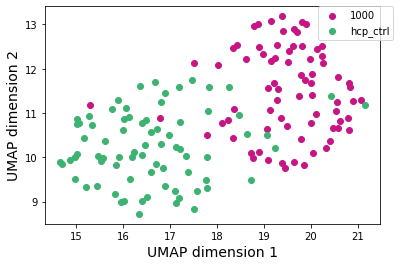

In [47]:
arr = embedding_1000
color_dict = {'hcp':'mediumseagreen', '1000': 'mediumvioletred'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_1000):
    ix = np.where(labels_1000 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='hcp':
        g_lab = 'hcp_ctrl'
    else:
        g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

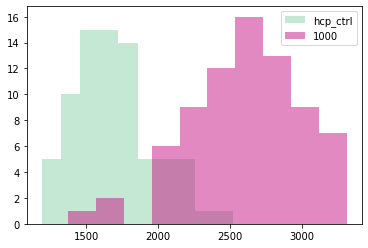

In [49]:
assert(len(df_encoded_hcp_X_1000.recon)==76)
assert(len(df_encoded_1000_X.recon)==75)
plt.subplot()
plt.hist(df_encoded_hcp_X_1000.recon, color='mediumseagreen', alpha=0.3, label='hcp_ctrl')
plt.hist(df_encoded_1000_X.recon, color='mediumvioletred', alpha=0.5, label='1000')
plt.legend()

In [50]:
F,p = mannwhitneyu(df_encoded_hcp_X_1000.loss, df_encoded_1000_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_1000.loss, df_encoded_1000_X.loss)
print(p)

4.307317708109786e-23
1.217414080770527e-24


### Quantification

#### SS_size = 200

In [52]:
X_200 = np.array(list(df_encoded_200_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_200['latent']))

X = np.array(list(df_encoded_hcp_X_200['latent']) + list(df_encoded_200_X['latent']))
label = np.array(['hcp' for k in range(len(X_hcp))] + ['200' for k in range(len(X_200))])

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.4, stratify=label, random_state=42)

>acc=0.556, est=0.515, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.528, est=0.542, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.444, est=0.494, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.611, est=0.458, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.500, est=0.570, cfg={'C': 1, 'penalty': 'l2'}


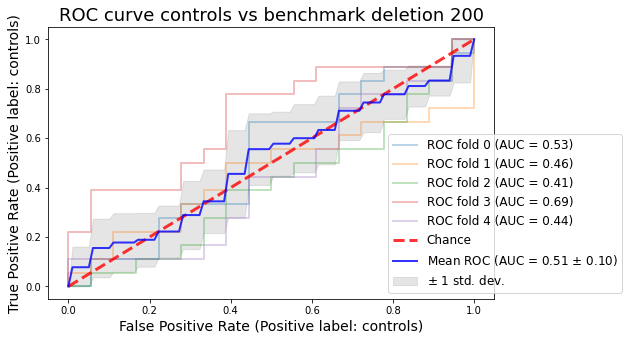

Accuracy: 0.528 (0.056)


In [53]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i+=1
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large', bbox_to_anchor=(1.3, 0))
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 200', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

#### SS_size = 500

In [54]:
X_500 = np.array(list(df_encoded_500_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_500['latent']))
X = np.array(list(df_encoded_hcp_X_500['latent']) + list(df_encoded_500_X['latent']))

#X_embedded_500 = TSNE(n_components=2).fit_transform(X_all)
label = np.array(list(df_encoded_hcp_X_500['Group']) + ['500' for k in range(len(df_encoded_500_X))])

>acc=0.786, est=0.484, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.500, est=0.560, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.571, est=0.644, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.538, est=0.764, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.692, est=0.527, cfg={'C': 0.7, 'penalty': 'l2'}


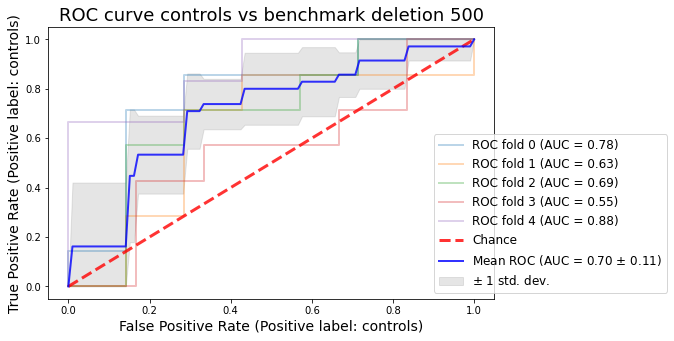

Accuracy: 0.618 (0.106)


In [55]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0


for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    i+=1

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large', bbox_to_anchor=(1.4, 0))
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 500', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

#### SS_size = 700

In [56]:
X_700 = np.array(list(df_encoded_700_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_700['latent']))
X = np.array(list(df_encoded_hcp_X_700['latent']) + list(df_encoded_700_X['latent']))

label = np.array(list(df_encoded_hcp_X_700['Group']) + ['700' for k in range(len(df_encoded_700_X))])

>acc=0.864, est=0.733, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.818, est=0.721, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.727, est=0.733, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.667, est=0.744, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.762, est=0.815, cfg={'C': 0.7, 'penalty': 'l2'}


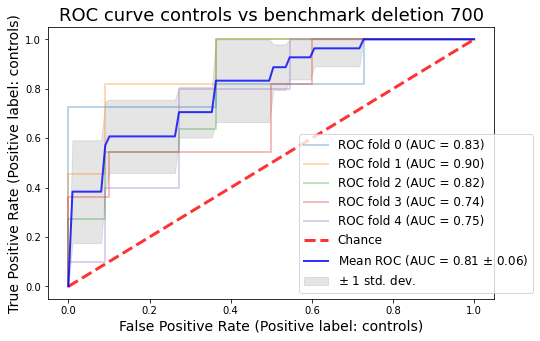

Accuracy: 0.768 (0.069)


In [57]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large', bbox_to_anchor=(1.1, 0))
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 700', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

#### SS_size = 1000

In [58]:
X_1000 = np.array(list(df_encoded_1000_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_1000['latent']))
X = np.array(list(df_encoded_hcp_X_1000['latent']) + list(df_encoded_1000_X['latent']))

label = np.array(list(df_encoded_hcp_X_1000['Group']) + ['1000' for k in range(len(df_encoded_1000_X))])

>acc=0.806, est=0.858, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.900, est=0.868, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.900, est=0.892, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.900, est=0.926, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.933, est=0.917, cfg={'C': 0.7, 'penalty': 'l2'}


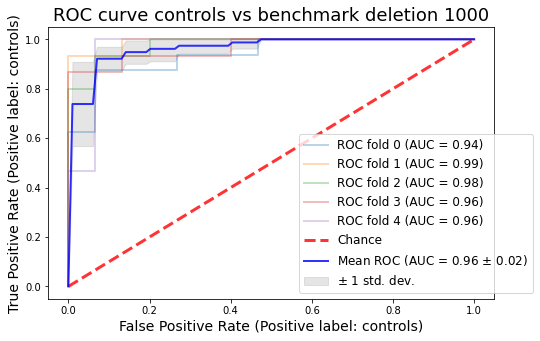

Accuracy: 0.888 (0.043)


In [59]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large', bbox_to_anchor=(1.1, 0))
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 1000', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

## Benchmark Asymmetry

In [4]:
data_dir = '/neurospin/dico/lguillon/distmap/benchmark/asymmetry/'

In [5]:
distmaps_asym = np.load(os.path.join(data_dir, "asym_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_asym = np.load(os.path.join(data_dir, "sub_id.npy"))

subset_asym = SkeletonDataset(dataframe=distmaps_asym,
                         filenames=filenames_asym,
                         data_transforms=False)
loader_asym = torch.utils.data.DataLoader(
               subset_asym,
               batch_size=1,
               num_workers=1,
               shuffle=False)

In [6]:
dico_set_loaders = {'asymmetry': loader_asym}

root_dir = '/neurospin/dico/lguillon/distmap/benchmark/results/'

criterion = nn.MSELoss(reduction='sum')
tester_asym = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_asym = tester_asym.test()
encoded_asym = {loader_name:[results_asym[loader_name][k][1] for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_asym = {loader_name:[int(results_asym[loader_name][k][0].cpu().detach().numpy()) for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_asym = {loader_name:[int(results_asym[loader_name][k][2].cpu().detach().numpy()) for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_asym = {loader_name:[results_asym[loader_name][k][3].cpu().detach().numpy() for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

asymmetry
[0.0000000e+00 7.4386597e-05 8.0347061e-05 ... 9.9866486e-01 9.9900138e-01
 9.9985051e-01]
[0.0000000e+00 6.6757202e-06 9.7751617e-06 ... 9.9760747e-01 9.9883580e-01
 9.9907076e-01]
[0.0000000e+00 9.0599060e-05 9.3936920e-05 ... 9.9952471e-01 9.9961555e-01
 9.9994659e-01]
[0.0000000e+00 8.5592270e-05 1.1754036e-04 ... 9.9909747e-01 9.9942851e-01
 9.9964750e-01]
[0.0000000e+00 4.2200089e-05 4.6730042e-05 ... 9.9815214e-01 9.9831235e-01
 9.9921489e-01]
[0.000000e+00 7.057190e-05 7.081032e-05 ... 9.992684e-01 9.994339e-01
 9.994767e-01]
[0.0000000e+00 5.1259995e-05 6.2942505e-05 ... 9.9898529e-01 9.9905300e-01
 9.9923515e-01]
[0.0000000e+00 2.3841858e-07 4.7683716e-07 ... 9.9946594e-01 9.9964213e-01
 9.9992526e-01]
[0.0000000e+00 2.1934509e-05 2.5749207e-05 ... 9.9798131e-01 9.9864352e-01
 9.9990916e-01]
[0.0000000e+00 9.0122223e-05 9.6797943e-05 ... 9.9835503e-01 9.9870765e-01
 9.9986112e-01]
[0.0000000e+00 1.5711784e-04 1.5950203e-04 ... 9.9754870e-01 9.9932742e-01
 9.9953532e

[0.0000000e+00 1.0728836e-05 1.4543533e-05 ... 9.9929500e-01 9.9955666e-01
 9.9986649e-01]
[0.0000000e+00 3.5762787e-06 4.0531158e-06 ... 9.9884474e-01 9.9900663e-01
 9.9948204e-01]
[0.0000000e+00 2.5033951e-05 2.5749207e-05 ... 9.9965286e-01 9.9975431e-01
 9.9989319e-01]
[0.00000000e+00 1.11579895e-04 1.28030777e-04 ... 9.99215484e-01
 9.99647498e-01 9.99679565e-01]
[0.0000000e+00 3.0755997e-05 5.8650970e-05 ... 9.9744844e-01 9.9788880e-01
 9.9965823e-01]
[0.0000000e+00 8.3446503e-05 9.1314316e-05 ... 9.9947131e-01 9.9977040e-01
 9.9989319e-01]
[0.0000000e+00 4.7445297e-05 6.7472458e-05 ... 9.9930573e-01 9.9950337e-01
 9.9995720e-01]
[0.0000000e+00 1.2636185e-05 1.7166138e-05 ... 9.9840856e-01 9.9919438e-01
 9.9980772e-01]
[0.0000000e+00 1.2731552e-04 1.2755394e-04 ... 9.9690247e-01 9.9845123e-01
 9.9868631e-01]
[0.0000000e+00 2.5749207e-05 3.8385391e-05 ... 9.9944460e-01 9.9948752e-01
 9.9988246e-01]
[0.0000000e+00 1.0967255e-04 1.1181831e-04 ... 9.9922025e-01 9.9986112e-01
 9.998931

[0.0000000e+00 3.6478043e-05 4.1961670e-05 ... 9.9806678e-01 9.9889982e-01
 9.9951398e-01]
[0.0000000e+00 1.1920929e-06 1.4305115e-06 ... 9.9887848e-01 9.9944460e-01
 9.9965823e-01]
[0.0000000e+00 2.1314621e-04 2.4342537e-04 ... 9.9961555e-01 9.9975967e-01
 9.9981749e-01]
[0.0000000e+00 4.4107437e-05 4.4822693e-05 ... 9.9839783e-01 9.9856877e-01
 9.9925363e-01]
[0.0000000e+00 3.5285950e-05 4.6491623e-05 ... 9.9988246e-01 9.9993587e-01
 9.9995196e-01]
[0.0000000e+00 5.1259995e-05 5.5789948e-05 ... 9.9913490e-01 9.9936986e-01
 9.9980772e-01]
[0.0000000e+00 8.6545944e-05 9.6321106e-05 ... 9.9824822e-01 9.9888921e-01
 9.9967957e-01]
[0.0000000e+00 6.1035156e-05 6.1273575e-05 ... 9.9962080e-01 9.9967957e-01
 9.9987185e-01]
[0.0000000e+00 8.1777573e-05 8.4877014e-05 ... 9.9870372e-01 9.9929047e-01
 9.9942327e-01]
[0.0000000e+00 6.8426132e-05 7.3671341e-05 ... 9.9960482e-01 9.9961019e-01
 9.9992526e-01]
[0.000000e+00 6.246567e-05 6.914139e-05 ... 9.995301e-01 9.995407e-01
 9.997864e-01]
[0.00

In [13]:
df_encoded_asym = pd.DataFrame()
df_encoded_asym['latent'] = encoded_asym['asymmetry']
df_encoded_asym['loss'] = losses_asym['asymmetry']  
df_encoded_asym['recon'] = recon_asym['asymmetry']   
df_encoded_asym['input'] = input_asym['asymmetry'] 
df_encoded_asym['sub'] = list(filenames_asym) 

In [14]:
data_dir = "/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/"
df_encoded_hcp = pd.read_pickle(os.path.join(data_dir, "encoded_hcp.pkl"))[:200]

In [15]:
list_encoded_asym = random.sample(list(df_encoded_asym['sub']), 100)
df_encoded_asym_X = df_encoded_asym[df_encoded_asym['sub'].astype(int).isin(list_encoded_asym)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_asym_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X_asym = np.array(list(df_encoded_asym_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_asym_X['latent']))

labels_asym = np.array(list(df_encoded_hcp_X['Group']) + ['asymmetry' for k in range(len(df_encoded_asym_X))])
reducer = umap.UMAP(random_state=14)
embedding_asym = reducer.fit_transform(X_all)

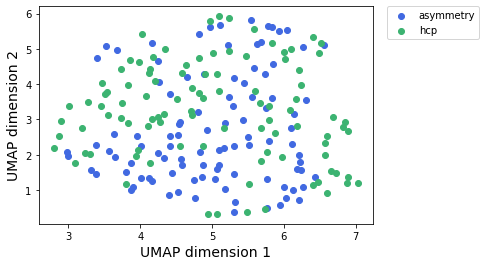

In [16]:
arr = embedding_asym
color_dict = {'hcp':'mediumseagreen', 'asymmetry': 'royalblue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_asym):
    ix = np.where(labels_asym == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [11]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [12]:
print(centeroidnp(embedding_asym[100:]))
print(centeroidnp(embedding_asym[:100]))

(13.445821533203125, 5.199754638671875)
(13.276522216796875, 5.65732666015625)


### Interpolation from one ctrl subject to one asym subject

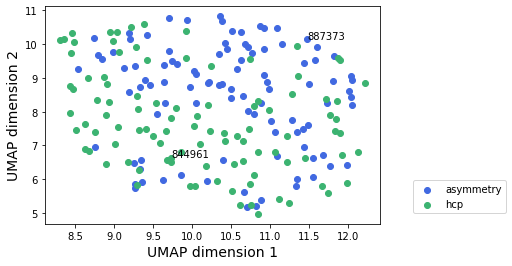

In [224]:
arr = embedding_asym
color_dict = {'hcp':'mediumseagreen', 'asymmetry': 'royalblue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_asym):
    ix = np.where(labels_asym == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

# ax.scatter(centeroidnp(embedding_asym[:100])[0], 
#            centeroidnp(embedding_asym[:100])[1], c='mediumseagreen', marker='x')
# ax.scatter(centeroidnp(embedding_asym[100:])[0],
#            centeroidnp(embedding_asym[100:])[1], c='royalblue', marker='x')

for i, txt in enumerate(list(df_encoded_asym_X['sub'])):
    if txt=='887373':
        ax.annotate(txt, (embedding_asym[100:][i][0], embedding_asym[100:][i][1]))
for i, txt in enumerate(list(df_encoded_hcp_X['sub'])):
    if txt==844961:
        ax.annotate(txt, (embedding_asym[:100][i][0], embedding_asym[:100][i][1]))
    
plt.legend(bbox_to_anchor=(1.1,0.2), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()



In [237]:
enc = [z_ctrl[0]] + [z_ctrl[0] + ((z_asym[0]-z_ctrl[0])/5)*k for k in [1,2,3,4]] + [z_asym[0]]

In [17]:
#z_ctrl = df_encoded_hcp_X[df_encoded_hcp_X['sub']==844961].latent.values
z_asym = df_encoded_asym_X[df_encoded_asym_X['sub']=='887373'].latent.values

# list_enc = [z_ctrl[0]] + [z_ctrl[0] + ((z_asym[0]-z_ctrl[0])/5)*k for k in [1,2,3,4]] + [z_asym[0]]

# arr_out = []
# values = []

# for k in range(6):
#     enc = list_enc[k]
#     z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
#     z = torch.unsqueeze(z, dim=0)
#     out = model.decode(z)
#     output = torch.argmax(out, dim=1)
#     out = np.array(np.squeeze(output).cpu().detach().numpy())
#     arr_out.append(out)
#     values.append(f"step_{k}")

In [18]:
z_asym

array([array([-1.9794729e-01, -1.9451113e-01,  2.0234718e+00,  1.5757270e-01,
        1.0327090e+00,  2.5652385e-01, -7.5875014e-01, -1.1033616e+00,
       -4.6505085e-01, -1.3414652e+00,  2.3093159e+00,  6.0866058e-01,
       -1.6933047e+00, -3.0196400e-03, -2.8040462e+00,  1.2349232e+00,
        6.2035662e-01,  1.5709012e+00, -1.1747695e+00,  7.9845822e-01,
       -1.6150270e+00, -2.3863050e-01, -1.6429988e+00,  4.7629035e-01,
       -1.3172868e+00, -5.3978288e-01,  1.1128479e+00,  7.9730228e-02,
        1.2004014e+00, -1.4850077e-01, -1.5514683e+00, -7.7526236e-01,
       -1.8087409e+00,  8.0673940e-02,  6.3608521e-01,  7.2292358e-01,
        1.1329124e+00, -1.0036907e+00, -1.9433257e-01,  7.5419307e-02,
        1.1559767e+00,  2.2632232e+00, -2.2802558e+00,  1.7019668e-01,
       -2.3697376e+00, -1.1252018e+00,  2.1782854e+00,  1.6454810e-01,
       -5.6728113e-02, -3.9049947e-01, -1.3699955e+00, -5.8059382e-01,
        1.3982245e+00,  1.5987445e+00,  3.2455645e+00, -1.2797143e+00,

In [19]:
z = torch.from_numpy(z_asym[0]).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
output = torch.argmax(out, dim=1)
out = np.array(np.squeeze(output).cpu().detach().numpy())

In [20]:
np.unique(out)

array([0])

In [262]:
tgt_dir = '/neurospin/dico/lguillon/distmap/results_benchmark/'
for k in range(6):
    np.save(f"{tgt_dir}skel_step_{k}", arr_out[k])
#     aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), 
#                                                           voxel_size=(1,1,1)), 
#                 f"{tgt_dir}interpolation_bucket_step_{k}.bck")

### Classification

>acc=0.875, est=0.756, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.800, est=0.806, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.675, est=0.838, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.850, est=0.738, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.725, est=0.725, cfg={'C': 0.7, 'penalty': 'l2'}


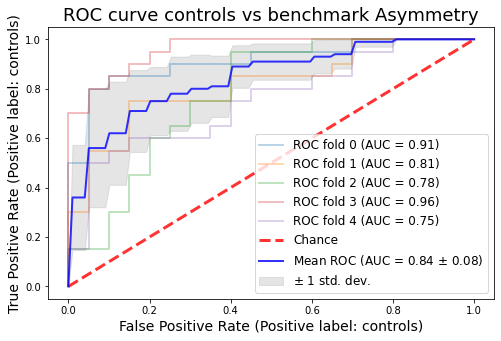

Accuracy: 0.785 (0.075)


In [171]:
X_train, X_test, y_train, y_test = train_test_split(X_all, labels_asym, test_size=0.4, stratify=labels_asym, random_state=42)

fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X_all, labels_asym):
    X_train, X_test = X_all[train_ix, :], X_all[test_ix, :]
    y_train, y_test = labels_asym[train_ix], labels_asym[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1 
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark Asymmetry', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

In [176]:
imp = best_model.coef_
imp_abs = list([abs(imp[0][k]) for k in range(len(imp[0]))])
imp_abs, names = zip(*sorted(list(zip(list(imp[0]), [k for k in range(len(imp_abs))]))))
print(imp_abs[-5:], names[-5:])

(0.3385700565011172, 0.3394758425379513, 0.37642017712475984, 0.38701131883482176, 0.436521584567181) (38, 30, 63, 61, 72)


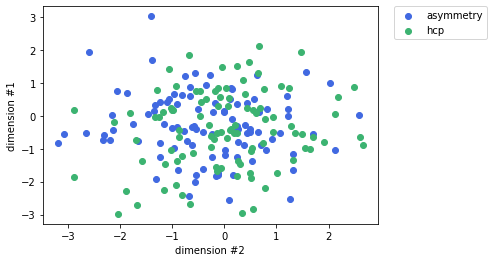

In [175]:
color_dict = {'hcp': 'mediumseagreen', 'asymmetry': 'royalblue'}
most_imp = [61,63]
arr = np.array([np.array([X_all[i][k] for k in most_imp]) for i in range(len(X_all))])

fig = plt.figure()
ax = fig.add_subplot(111)

for g in np.unique(labels_asym):
    #if g == 'HCP' or g == 'leftHanders':
    ix = np.where(labels_asym == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    #ax.scatter(arr[ix][0], arr[ix][1], arr[ix][2], c = color_dict[g], label = g)
    g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('dimension #2')
plt.ylabel('dimension #1')
    
#ax.legend(fontsize=14)
plt.show()

## Folding space - loss distributions

In [50]:
len(df_encoded_deletion)

507

In [51]:
len(df_encoded_200_X)

93

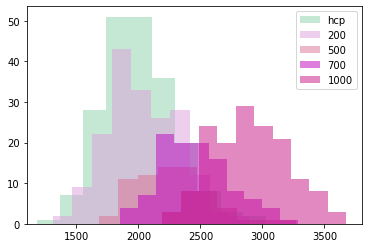

In [35]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='200'].loss, color='plum', alpha=0.5, label='200')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='500'].loss, color='palevioletred', alpha=0.5, label='500')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='700'].loss, color='m', alpha=0.5, label='700') 
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='1000'].loss, color='mediumvioletred', alpha=0.5, label='1000')
plt.legend()

In [83]:
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='200'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='500'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='700'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='1000'].loss)
print(p)

0.13405716752885355
8.063715007845529e-10
1.5333475604152505e-26
2.882310954362431e-54


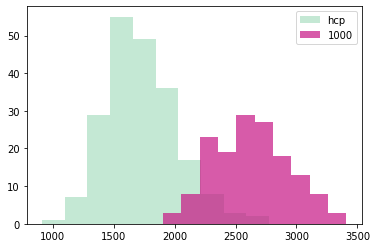

In [81]:
plt.subplot()
plt.hist(df_encoded_hcp.recon, color='mediumseagreen', alpha=0.3, label='hcp')
#plt.hist(df_encoded_deletion[df_encoded_deletion.group=='200'].recon, color='plum', alpha=0.5, label='200')
#plt.hist(df_encoded_deletion[df_encoded_deletion.group=='500'].recon, color='palevioletred', alpha=0.7, label='500')
#plt.hist(df_encoded_deletion[df_encoded_deletion.group=='700'].recon, color='m', alpha=0.5, label='700') 
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='1000'].recon, color='mediumvioletred', alpha=0.7, label='1000')
plt.legend()

In [116]:
list_encoded_200 = random.sample(list(deletion_200['sub']), 100)
df_encoded_200_X = deletion_200[deletion_200['sub'].astype(int).isin(list_encoded_200)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_200_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

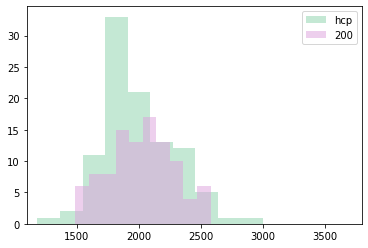

In [117]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_200_X.loss, color='plum', alpha=0.5, label='200')
plt.legend()

In [118]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_200_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_200_X.loss)
print(p)

0.20967579320349722
0.26055273160812736


In [119]:
df_encoded_500_X = deletion_500

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(deletion_500['sub'].astype(int))))
random_ctrl = random.sample(list_ctrl, 100)
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

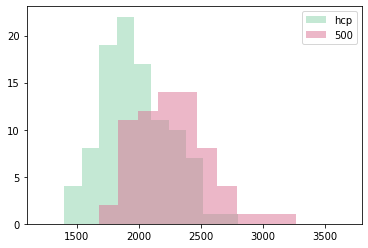

In [120]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_500_X.loss, color='palevioletred', alpha=0.5, label='500')
plt.legend()

In [121]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_500_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_500_X.loss)
print(p)

1.0737435822935459e-09
1.1089679835628955e-07


In [122]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 100)
df_encoded_700_X = deletion_700[deletion_700['sub'].astype(int).isin(list_encoded_700)]
list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_700_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

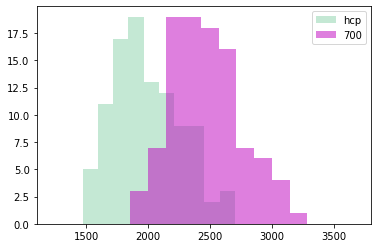

In [123]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_700_X.loss, color='m', alpha=0.5, label='700') 
plt.legend()

In [124]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_700_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_700_X.loss)
print(p)

2.706751769689624e-20
3.2764005184650757e-17


In [125]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 100)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].astype(int).isin(list_encoded_1000)]
list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_1000_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

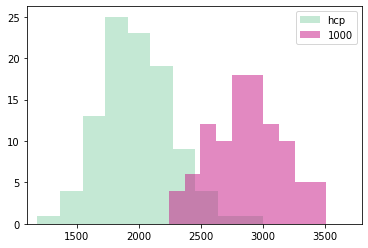

In [126]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_1000_X.loss, color='mediumvioletred', alpha=0.5, label='1000') 
plt.legend()

In [127]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_1000_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_1000_X.loss)
print(p)

3.674315979879044e-32
5.774179148531572e-37


In [128]:
df_200_500 = pd.merge(deletion_200, deletion_500, how='inner', on='sub', suffixes=('_200', '_500'))
df_700_1000 = pd.merge(deletion_700, deletion_1000, how='inner', on='sub', suffixes=('_700', '_1000'))
deletion_all = pd.merge(df_200_500, df_700_1000, how='inner', on='sub')

In [130]:
list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(deletion_all['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [262]:
# plt.subplot()
# plt.xlim([1100, 3800])
# plt.hist(df_encoded_hcp_X[:50].loss, color='mediumseagreen', alpha=0.3, label='hcp')
# # plt.scatter(deletion_all.loss_200[:1], [1], color='plum', alpha=0.8, label='200') 
# # plt.scatter(deletion_all.loss_500[:1], [1], color='palevioletred', alpha=0.8, label='500') 
# # plt.scatter(deletion_all.loss_700[:1], [1], color='m', alpha=0.8, label='700') 
# # plt.scatter(deletion_all.loss_1000[:1], [1], color='mediumvioletred', alpha=0.8, label='1000') 

# plt.scatter(deletion_all.loss_200[1], [2], color='plum', alpha=0.8, label='200', marker='o') 
# plt.scatter(deletion_all.loss_500[1], [2], color='palevioletred', alpha=0.8, label='500', marker='o') 
# plt.scatter(deletion_all.loss_700[1], [2], color='m', alpha=0.8, label='700', marker='o') 
# plt.scatter(deletion_all.loss_1000[1], [2], color='mediumvioletred', alpha=0.8, label='1000', marker='o') 

# plt.plot(deletion_all.loss_200[2], [2], color='plum', alpha=0.8, label='200', marker='->') 
# plt.scatter(deletion_all.loss_500[2], [2], color='palevioletred', alpha=0.8, label='500', marker='->') 
# plt.scatter(deletion_all.loss_700[2], [2], color='m', alpha=0.8, label='700', marker='->') 
# plt.scatter(deletion_all.loss_1000[2], [2], color='mediumvioletred', alpha=0.8, label='1000', marker='->') 

# # plt.scatter(deletion_all.loss_200[3], [3], color='plum', alpha=0.8, label='200', marker='X') 
# # plt.scatter(deletion_all.loss_500[3], [3], color='palevioletred', alpha=0.8, label='500', marker='X') 
# # plt.scatter(deletion_all.loss_700[3], [3], color='m', alpha=0.8, label='700', marker='X') 
# # plt.scatter(deletion_all.loss_1000[3], [3], color='mediumvioletred', alpha=0.8, label='1000', marker='X') 

# # plt.hist(deletion_all.loss_700, color='m', alpha=0.5, label='700') 
# # plt.hist(deletion_all.loss_1000, color='mediumvioletred', alpha=0.5, label='1000') 


# # plt.plot(np.histogram(list(deletion_all.loss_200))[1][:-1],np.histogram(list(deletion_all.loss_200))[0], color='plum', alpha=0.8, label='200') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 
# # plt.plot(np.histogram(list(deletion_all.loss_500))[1][:-1],np.histogram(list(deletion_all.loss_500))[0], color='palevioletred', alpha=0.8, label='500') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 
# # plt.plot(np.histogram(list(deletion_all.loss_700))[1][:-1],np.histogram(list(deletion_all.loss_700))[0], color='m', alpha=0.8, label='500') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 
# # plt.plot(np.histogram(list(deletion_all.loss_1000))[1][:-1],np.histogram(list(deletion_all.loss_1000))[0], color='mediumvioletred', alpha=0.8, label='500') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 

# plt.legend()

In [261]:
delta_loss_200, delta_loss_500, delta_loss_700, delta_loss_1000 = [], [], [], []
for k in range(len(deletion_all)):
    sub = deletion_all['sub'][k]
    delta = (deletion_all['loss_200'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==int(sub)].loss.values)[0]
    delta_loss_200.append(delta)
    
    delta = (deletion_all['loss_500'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==int(sub)].loss.values)[0]
    delta_loss_500.append(delta)
    
    delta = (deletion_all['loss_700'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==int(sub)].loss.values)[0]
    delta_loss_700.append(delta)
    
    delta = (deletion_all['loss_1000'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==int(sub)].loss.values)[0]
    delta_loss_1000.append(delta)

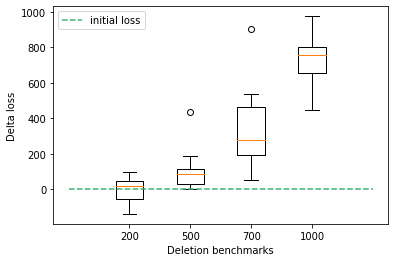

In [260]:
plt.boxplot((delta_loss_200, delta_loss_500, delta_loss_700, delta_loss_1000),
            labels=('200','500','700','1000'))
plt.plot(['0','200','500','700','1000', '2000'], [0, 0, 0, 0, 0, 0], color='mediumseagreen', ls='--',
        label='initial loss')
plt.xlabel('Deletion benchmarks')
plt.ylabel('Delta loss')
plt.legend()

### Asymmetry

In [269]:
list_encoded_asym = random.sample(list(df_encoded_asym['sub']), 100)
df_encoded_asym_X = df_encoded_asym[df_encoded_asym['sub'].astype(int).isin(list_encoded_asym)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_asym_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

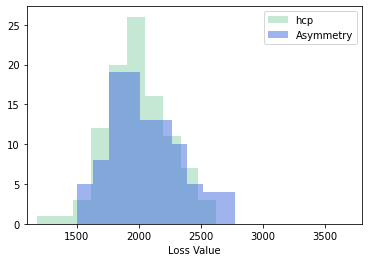

In [272]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_asym_X.loss, color='royalblue', alpha=0.5, label='Asymmetry') 
plt.xlabel('Loss Value')
plt.legend()

In [273]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_asym_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_asym_X.loss)
print(p)

0.14839642982370554
0.34388571222170217
